In [1]:
!pip install torch torchaudio torchvision
!pip install numpy
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.5 MB/s eta 0:00:00


In [2]:
import os
import torchaudio
import torch
import torchaudio.functional as F

import matplotlib.pyplot as plt

import numpy as np

## Retrieve music and compute their spectrograms

In [3]:
!unzip slices.zip -d ./data/

Archive:  slices.zip
  inflating: ./data/slices/slice_1.wav  
  inflating: ./data/slices/slice_10.wav  
  inflating: ./data/slices/slice_11.wav  
  inflating: ./data/slices/slice_12.wav  
  inflating: ./data/slices/slice_13.wav  
  inflating: ./data/slices/slice_14.wav  
  inflating: ./data/slices/slice_15.wav  
  inflating: ./data/slices/slice_16.wav  
  inflating: ./data/slices/slice_17.wav  
  inflating: ./data/slices/slice_18.wav  
  inflating: ./data/slices/slice_19.wav  
  inflating: ./data/slices/slice_2.wav  
  inflating: ./data/slices/slice_20.wav  
  inflating: ./data/slices/slice_21.wav  
  inflating: ./data/slices/slice_22.wav  
  inflating: ./data/slices/slice_23.wav  
  inflating: ./data/slices/slice_24.wav  
  inflating: ./data/slices/slice_25.wav  
  inflating: ./data/slices/slice_26.wav  
  inflating: ./data/slices/slice_27.wav  
  inflating: ./data/slices/slice_28.wav  
  inflating: ./data/slices/slice_29.wav  
  inflating: ./data/slices/slice_3.wav  
  inflating: ./d

In [4]:
def split_wav(wav, num_splits=2):
    """Split a waveform into `num_splits` equal parts along time axis."""
    c, L = wav.shape
    split_len = L // num_splits
    splits = []
    for i in range(num_splits):
        start = i * split_len
        end = (i + 1) * split_len if i < num_splits - 1 else L
        splits.append(wav[:, start:end])
    return splits

def get_spectrogram(wav):
  # convert to mono
  wav = wav.mean(dim=0, keepdim=True)

  #get spectrogram
  wav_stft = torch.stft(wav, 1024, window=torch.hamming_window(1024), return_complex=True, hop_length=256).abs()
  wav_stft = torch.log1p(wav_stft)

  wav_stft = torch.clamp(wav_stft, min=1e-6) #avoid 0 values

  # normalize
  wav_stft = (wav_stft - wav_stft.min()) / (wav_stft.max() - wav_stft.min() + 1e-6)

  return wav_stft


torch.Size([126, 513, 2584])
torch.Size([113, 513, 2584])
torch.Size([13, 513, 2584])


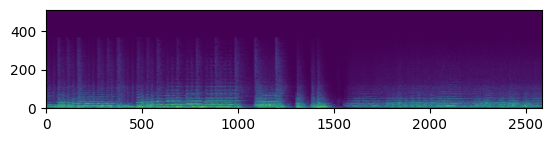

In [5]:
# get all music
path = 'data/slices/'
files = os.listdir(path)

stfts = []
max_len = 0
for i, fl in enumerate(files):
  wav, fs = torchaudio.load(path + fl)

  for wav_part in split_wav(wav, num_splits=2):

      wav_stft = get_spectrogram(wav_part)

      stfts.append(wav_stft.squeeze())
      if wav_stft.shape[-1] > max_len:
          max_len = wav_stft.shape[-1]


musics = stfts


musics = torch.stack(musics)
print(musics.shape)

cutpt = int(musics.shape[0]*0.9)
musics_tr = musics[:cutpt, :]
musics_test = musics[cutpt:, :]
print(musics_tr.shape)
print(musics_test.shape)


plt.imshow(musics_tr.cpu()[5], origin='lower')


## Defining a CNN to get latent representation of spectrograms

In [6]:
import torch
import torch.nn as nn

class conv_encoder(nn.Module):
    def __init__(self, K=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=K, kernel_size=3, stride=2, padding=1)

        self.convt1 = nn.ConvTranspose2d(in_channels=K, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.convt3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1)

        self.nonl = nn.ReLU()

    def forward(self, x, verbose=False):
        h1 = self.conv1(x)
        h1 = self.nonl(h1)

        h2 = self.conv2(h1)
        h2 = self.nonl(h2)

        h3 = self.conv3(h2)

        h4 = self.convt1(h3)
        h4 = self.nonl(h4)

        h5 = self.convt2(h4)
        h5 = self.nonl(h5)

        xhat = self.convt3(h5)
        if verbose:
          print(h1.shape)
          print(h2.shape)
          print(h3.shape)

          print(h4.shape)
          print(h5.shape)
          print(xhat.shape)
        return xhat, h3


## Model training

In [7]:
model = conv_encoder(K=32).to('cuda')
model.train()
opt = torch.optim.Adam(params=model.parameters(), lr=1e-4)

eps = 1e-3
batch_size = 4
num_epochs = 2000
N = musics_tr.shape[0]

criterion = nn.MSELoss()

for e in range(num_epochs):
  model.train()

  # shuffle indices
  perm = torch.randint(0, N, (batch_size,))
  total_loss = 0.0

  batch = musics_tr[perm].unsqueeze(1).to("cuda")
  opt.zero_grad()

  out, _ = model.forward(batch)
  H, W = out.shape[-2], out.shape[-1]
  batch = batch[..., :H, :W]

  #using MSE loss
  loss = criterion(out, batch)
  loss.backward()

  opt.step()

  if e % 100 == 0:
    print('ep {} loss val {}'.format(e, loss.item()))


ep 0 loss val 0.13970372080802917
ep 100 loss val 0.004992113448679447
ep 200 loss val 0.0027598231099545956
ep 300 loss val 0.0019100727513432503
ep 400 loss val 0.0028070821426808834
ep 500 loss val 0.0021521204616874456
ep 600 loss val 0.002027659211307764
ep 700 loss val 0.0014183460734784603
ep 800 loss val 0.0013415771536529064
ep 900 loss val 0.001204854459501803
ep 1000 loss val 0.0009569688118062913
ep 1100 loss val 0.0012515293201431632
ep 1200 loss val 0.0011244340566918254
ep 1300 loss val 0.0008899950189515948
ep 1400 loss val 0.0010786107741296291
ep 1500 loss val 0.001067264354787767
ep 1600 loss val 0.0006414460367523134
ep 1700 loss val 0.001040083123371005
ep 1800 loss val 0.0008280515903607011
ep 1900 loss val 0.0006623102817684412


## Model Tests

In [8]:
model.eval()
with torch.no_grad():
    batch = musics_test[:].unsqueeze(1).to("cuda")
    out, _ = model(batch)

    # crop batch to match output
    H, W = out.shape[-2], out.shape[-1]
    batch_cropped = batch[..., :H, :W]

    loss = nn.MSELoss()(out, batch_cropped)
    print("Test batch MSE:", loss.item())

Test batch MSE: 0.0008343738154508173


### FAD & MMD TESTS



In [25]:
def compute_covariance(x):
    N = x.shape[0]
    x_centered = x - x.mean(dim=0)
    cov = (x_centered.T @ x_centered) / (N - 1)
    return cov

def compute_FAD(embedding_group1, embedding_group2):
    device = embedding_group1.device

    mu_group1 = embedding_group1.mean(dim=0)
    sigma_group1 = compute_covariance(embedding_group1)

    mu_group2 = embedding_group2.mean(dim=0)
    sigma_group2 = compute_covariance(embedding_group2)

    eps = 1e-6
    sigma_group1 += eps * torch.eye(sigma_group1.shape[0], device=device)
    sigma_group2 += eps * torch.eye(sigma_group2.shape[0], device=device)

    return F.frechet_distance(mu_group1, sigma_group1, mu_group2, sigma_group2)

def compute_mmd(x, y, sigma=None):
    if sigma is None:
        sigma = torch.median(torch.cdist(x, y))

    xx = torch.cdist(x, x) ** 2
    yy = torch.cdist(y, y) ** 2
    xy = torch.cdist(x, y) ** 2

    k_xx = torch.exp(-xx / (2 * sigma**2))
    k_yy = torch.exp(-yy / (2 * sigma**2))
    k_xy = torch.exp(-xy / (2 * sigma**2))

    return k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()

In [26]:
model.eval()

# create 2 audio groups
music_group1 = musics_tr[:10].unsqueeze(0).transpose(0, 1).cuda()  # shape [B, 1, H, W]
music_group2 = musics_test[:10].unsqueeze(0).transpose(0, 1).cuda()

# Get models latents
latents1 = None
latents2= None
with torch.no_grad():
    _, latents1 = model(music_group1)  # latents1 = h3
    _, latents2 = model(music_group2)

print(latents1.shape)
print(latents2.shape)


# average embedding dimensions, does not impact accuracy because FAD and MMD are based on the mean and covariance
embeddings1 = latents1.mean(dim=[2,3])  # shape [B, C]
embeddings2 = latents2.mean(dim=[2,3])

print(embeddings1.shape)
print(embeddings2.shape)

print("FAD score embedding moyenne : ", compute_FAD(embeddings1, embeddings2).item())
print("MMD score embedding moyenne : ", compute_mmd(embeddings1, embeddings2).item())


# The score is low because the groups come from the same video of Pena being cut up, which the model was trained on.
# So, inevitably, the groups are similar
# (fad is a distance; the smaller it is, the more similar it is)


torch.Size([10, 32, 65, 323])
torch.Size([10, 32, 65, 323])
torch.Size([10, 32])
torch.Size([10, 32])
FAD score embedding moyenne :  0.08240047097206116
MMD score embedding moyenne :  0.13939547538757324


## Scores on generated musics

In [13]:
import os
[os.makedirs(f"/content/data/{name}", exist_ok=True) for name in ["LSTM", "AUDIOLDM", "MUSICGEN"]]

#!unzip musicGEN_generated.zip -d ./data/MUSICGEN
!unzip audioLDM_generated.zip -d ./data/AUDIOLDM
!unzip LSTM_generated.zip -d ./data/LSTM

Archive:  audioLDM_generated.zip
  inflating: ./data/AUDIOLDM/slice0.wav  
  inflating: ./data/AUDIOLDM/slice10.wav  
  inflating: ./data/AUDIOLDM/slice11.wav  
  inflating: ./data/AUDIOLDM/slice12.wav  
  inflating: ./data/AUDIOLDM/slice13.wav  
  inflating: ./data/AUDIOLDM/slice14.wav  
  inflating: ./data/AUDIOLDM/slice15.wav  
  inflating: ./data/AUDIOLDM/slice16.wav  
  inflating: ./data/AUDIOLDM/slice17.wav  
  inflating: ./data/AUDIOLDM/slice18.wav  
  inflating: ./data/AUDIOLDM/slice19.wav  
  inflating: ./data/AUDIOLDM/slice1.wav  
  inflating: ./data/AUDIOLDM/slice20.wav  
  inflating: ./data/AUDIOLDM/slice21.wav  
  inflating: ./data/AUDIOLDM/slice22.wav  
  inflating: ./data/AUDIOLDM/slice23.wav  
  inflating: ./data/AUDIOLDM/slice24.wav  
  inflating: ./data/AUDIOLDM/slice25.wav  
  inflating: ./data/AUDIOLDM/slice26.wav  
  inflating: ./data/AUDIOLDM/slice27.wav  
  inflating: ./data/AUDIOLDM/slice28.wav  
  inflating: ./data/AUDIOLDM/slice29.wav  
  inflating: ./data/AUD

In [14]:

def retrieve_music(path):
  files = os.listdir(path)
  stfts = []
  max_len = 0
  for i, fl in enumerate(files):
    wav, fs = torchaudio.load(path + fl)

    for wav_part in split_wav(wav, num_splits=2):

        wav_stft = get_spectrogram(wav_part)

        stfts.append(wav_stft.squeeze())
        if wav_stft.shape[-1] > max_len:
            max_len = wav_stft.shape[-1]

  return  torch.stack(stfts)


In [27]:
import torch

model.eval()

music_reference = musics.unsqueeze(0).transpose(0, 1).cuda() # shape [B, 1, H, W]
music_lstm = retrieve_music("./data/LSTM/").unsqueeze(0).transpose(0, 1).cuda()
#music_musicgen = retrieve_music("./data/MUSICGEN/").unsqueeze(0).transpose(0, 1).cuda()
music_audioldm = retrieve_music("./data/AUDIOLDM/").unsqueeze(0).transpose(0, 1).cuda()


reference_embeddings = []
lstm_embeddings = []
musicgen_embeddings = []
audioldm_embeddings = []


## computes latents per batch to lower cuda memory consumption during inference with the model
num_files = 60 # step
batch_size = 10

for i in range(0, num_files, batch_size):
  with torch.no_grad():
    _, reference_latents = model(music_reference[i : i + batch_size])
    _, lstm_latents = model(music_lstm[i : i + batch_size])
    #_, musicgen_latents = model(music_musicgen[i : i + batch_size])
    _, audioldm_latents = model(music_audioldm[i : i + batch_size])

    # average embedding dimensions, does not impact accuracy because FAD and MMD are based on the mean and covariance
    reference_embeddings.append( reference_latents.mean(dim=[2,3]) )  # shape [B, C]
    lstm_embeddings.append( lstm_latents.mean(dim=[2,3]) )
    #musicgen_embeddings.append( musicgen_latents.mean(dim=[2,3]) )
    audioldm_embeddings.append( audioldm_latents.mean(dim=[2,3]) )


    print(f"Processed {min(i + batch_size, num_files)}/{num_files}")


## concatenate back
reference_embeddings = torch.cat(reference_embeddings, dim=0)
lstm_embeddings = torch.cat(lstm_embeddings, dim=0)
#musicgen_embeddings = torch.cat(musicgen_embeddings, dim=0)
audioldm_embeddings = torch.cat(audioldm_embeddings, dim=0)


## Calculate the final score using all 60 samples
print("FAD score lstm embedding  : ", compute_FAD(reference_embeddings, lstm_embeddings).item())
print("MMD score lstm embedding : ", compute_mmd(reference_embeddings, lstm_embeddings).item())

# print("FAD score musicgen embedding  : ", compute_FAD(reference_embeddings, musicgen_embeddings).item())
# print("MMD score musicgen embedding : ", compute_mmd(reference_embeddings, musicgen_embeddings).item())

print("FAD score audioldm embedding  : ", compute_FAD(reference_embeddings, audioldm_embeddings).item())
print("MMD score audioldm embedding : ", compute_mmd(reference_embeddings, audioldm_embeddings).item())

Processed 10/60
Processed 20/60
Processed 30/60
Processed 40/60
Processed 50/60
Processed 60/60
FAD score lstm embedding  :  0.5864798426628113
MMD score lstm embedding :  0.4714473485946655
FAD score audioldm embedding  :  21.465234756469727
MMD score audioldm embedding :  0.7702922821044922
